In [1]:
import pandas as pd
import ast
from collections import Counter
import subprocess
import sys

# Step 1: Load CSV files into DataFrames
comments_df = pd.read_csv("/content/drive/MyDrive/CSE477/comments_output.csv")
captions_df = pd.read_csv("/content/drive/MyDrive/CSE477/captions_output.csv")

# Step 2: Ensure 'cleaned_tokens' column exists and contains list-like data
for df_name, df in [('comments_df', comments_df), ('captions_df', captions_df)]:
    if 'cleaned_tokens' not in df.columns:
        raise ValueError(f"'cleaned_tokens' column is missing in {df_name}")

    # Convert stringified lists to actual lists (if needed)
    df['cleaned_tokens'] = df['cleaned_tokens'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

# Step 3: Drop rows with missing or empty 'cleaned_tokens'
comments_df = comments_df[comments_df['cleaned_tokens'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
captions_df = captions_df[captions_df['cleaned_tokens'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Step 4: Use Counter to print top 20 unigrams
all_tokens = comments_df['cleaned_tokens'].explode().tolist() + captions_df['cleaned_tokens'].explode().tolist()
unigram_counts = Counter(all_tokens)
print("Top 20 unigrams:")
for word, freq in unigram_counts.most_common(20):
    print(f"{word}: {freq}")

# Step 5: Install mlxtend if not already installed
try:
    import mlxtend
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlxtend"])
    import mlxtend  # Re-import to confirm it's available


Top 20 unigrams:
going: 1209
okay: 912
data: 880
know: 830
right: 788
one: 776
let: 661
like: 608
actually: 549
model: 525
set: 492
mean: 442
point: 398
thats: 374
might: 348
class: 325
value: 324
say: 324
well: 323
label: 315


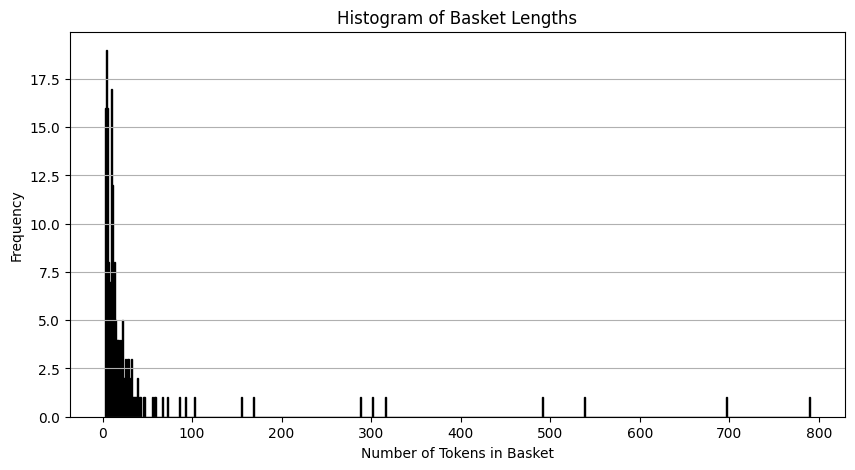

Total transactions: 207
Average basket length: 32.84
Minimum basket length: 3
Maximum basket length: 789


In [2]:
import matplotlib.pyplot as plt

# Step 6: Treat each 'cleaned_tokens' list as one basket (transaction)
# Step 7: Remove baskets with fewer than 3 tokens
# Step 8: Optionally remove duplicate tokens within each basket
# Here we choose to remove duplicates — set(remove_duplicates=True)
def process_baskets(df, remove_duplicates=True):
    baskets = df['cleaned_tokens'].tolist()
    if remove_duplicates:
        baskets = [list(set(basket)) for basket in baskets]
    baskets = [basket for basket in baskets if len(basket) >= 3]
    return baskets

# Combine baskets from both DataFrames
combined_baskets = process_baskets(comments_df) + process_baskets(captions_df)

# Step 9: Assign a unique transaction ID to each basket
# Not needed for the list of lists itself but useful for mapping if needed
transactions = [{"transaction_id": i, "items": basket} for i, basket in enumerate(combined_baskets)]

# Step 10: Store the cleaned transactions as a list of lists
cleaned_transactions = [t["items"] for t in transactions]

# Step 11: Plot a histogram of basket lengths
basket_lengths = [len(basket) for basket in cleaned_transactions]
plt.figure(figsize=(10, 5))
plt.hist(basket_lengths, bins=range(min(basket_lengths), max(basket_lengths)+2), edgecolor='black')
plt.title("Histogram of Basket Lengths")
plt.xlabel("Number of Tokens in Basket")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

# Step 12: Print statistics: average, min, max basket length
avg_len = sum(basket_lengths) / len(basket_lengths)
min_len = min(basket_lengths)
max_len = max(basket_lengths)

print(f"Total transactions: {len(cleaned_transactions)}")
print(f"Average basket length: {avg_len:.2f}")
print(f"Minimum basket length: {min_len}")
print(f"Maximum basket length: {max_len}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


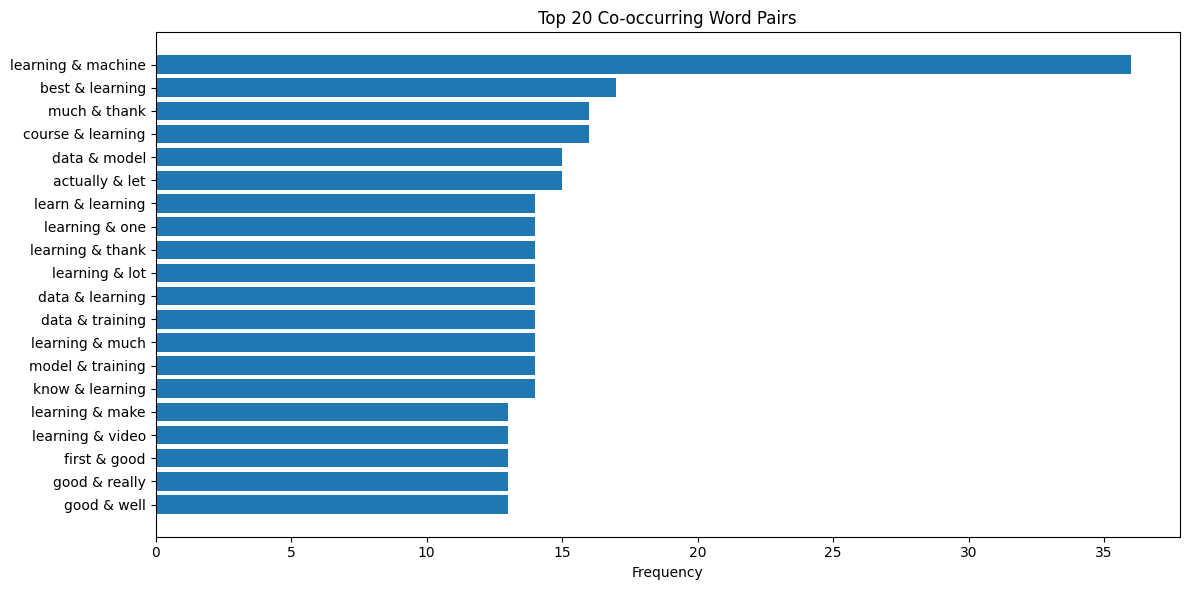

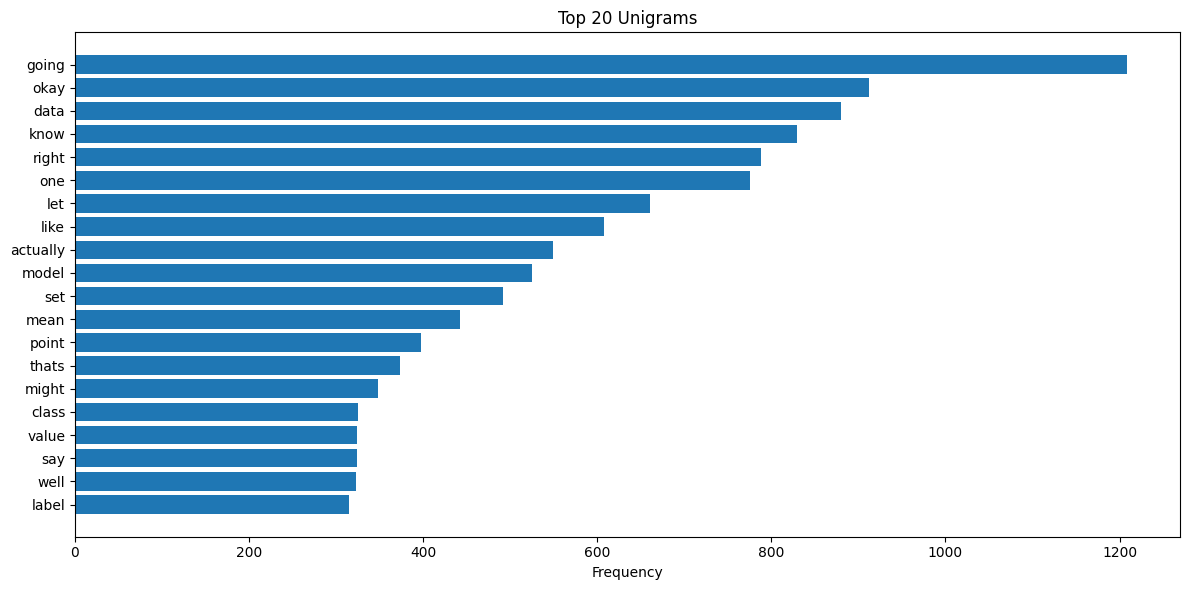

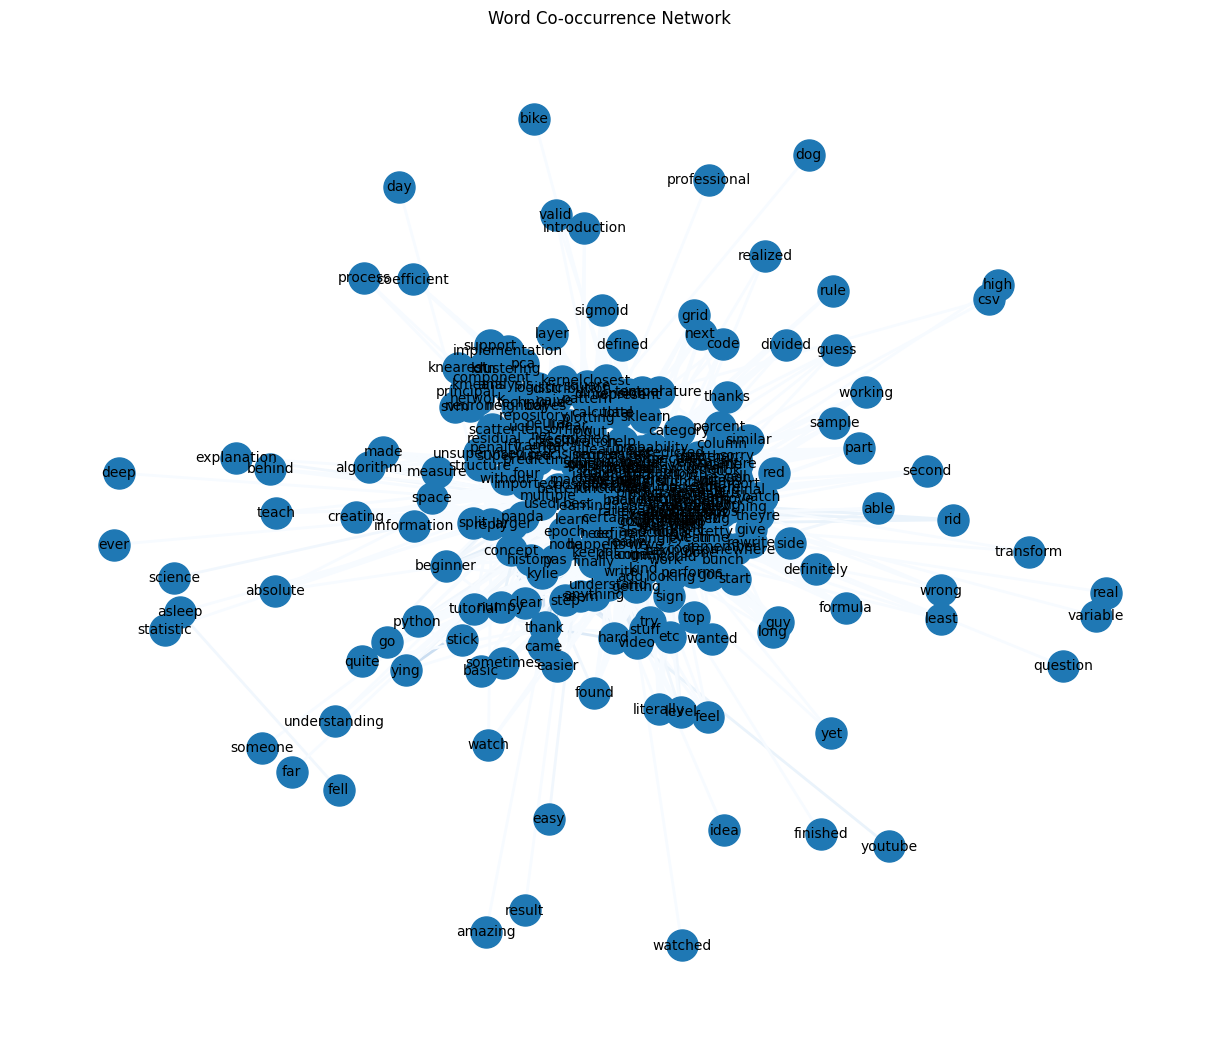

Exported co-occurrence data to cooccurrence_pairs.csv


In [3]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import nltk
from nltk.corpus import stopwords
import os

# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Step 13–14: Count pairwise word co-occurrences
pair_counter = Counter()
for basket in cleaned_transactions:
    pairs = itertools.combinations(sorted(set(basket)), 2)
    pair_counter.update(pairs)

# Step 15: Keep only those pairs with count >= 3
filtered_pairs = {pair: count for pair, count in pair_counter.items() if count >= 3}

# Step 16: Plot the top 20 co-occurring word pairs as a horizontal bar chart
top_pairs = Counter(filtered_pairs).most_common(20)
pair_labels = [' & '.join(pair) for pair, _ in top_pairs]
pair_values = [count for _, count in top_pairs]

plt.figure(figsize=(12, 6))
plt.barh(pair_labels[::-1], pair_values[::-1])
plt.title("Top 20 Co-occurring Word Pairs")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# Step 17: Compare with a unigram frequency bar chart
top_unigrams = unigram_counts.most_common(20)
unigram_labels = [word for word, _ in top_unigrams]
unigram_values = [count for _, count in top_unigrams]

plt.figure(figsize=(12, 6))
plt.barh(unigram_labels[::-1], unigram_values[::-1])
plt.title("Top 20 Unigrams")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# Step 18: Create a network graph (words = nodes, co-occurrence = edges)
G = nx.Graph()
for (w1, w2), count in filtered_pairs.items():
    G.add_edge(w1, w2, weight=count)

# Optional filtering for better visuals (remove edges < threshold)
edge_threshold = 5
G_filtered = nx.Graph(
    [(u, v, d) for u, v, d in G.edges(data=True) if d['weight'] >= edge_threshold]
)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_filtered, k=0.5)
weights = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
nx.draw(G_filtered, pos, with_labels=True, node_size=500, font_size=10,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
plt.title("Word Co-occurrence Network")
plt.show()

# Step 19: Remove stopwords from co-occurring pairs
filtered_pairs_no_stop = {
    pair: count for pair, count in filtered_pairs.items()
    if pair[0] not in stop_words and pair[1] not in stop_words
}

# Step 20: Export the co-occurrence data to
df_cooccurrence = pd.DataFrame([
    {'word1': w1, 'word2': w2, 'count': count}
    for (w1, w2), count in filtered_pairs_no_stop.items()
])

df_cooccurrence.to_csv("/content/drive/MyDrive/CSE477/cooccurrence_pairs.csv", index=False)
print("Exported co-occurrence data to cooccurrence_pairs.csv")

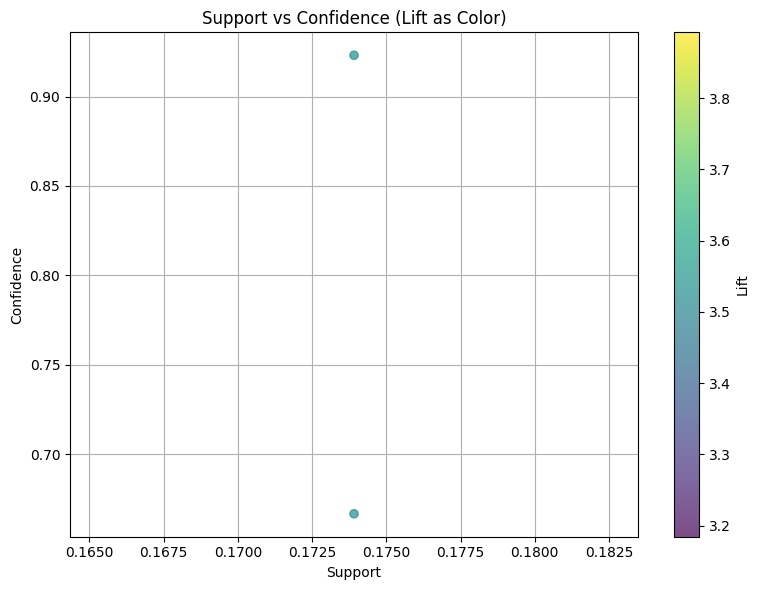

Saved frequent itemsets to frequent_itemsets.csv
Saved association rules to association_rules.csv


In [4]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# === Step 21: One-hot encode the transaction list ===
te = TransactionEncoder()
te_ary = te.fit(cleaned_transactions).transform(cleaned_transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# === Step 22–23: Run Apriori with different min_supports ===
# For association_rules, we use support = 0.1 (lowest), and retain all lengths
frequent_itemsets_all = apriori(df_encoded, min_support=0.1, use_colnames=True)

# === Step 24: Keep only 2- and 3-itemsets for export/visualization ===
frequent_itemsets = frequent_itemsets_all.copy()
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets_filtered = frequent_itemsets[frequent_itemsets['length'].isin([2, 3])]

# === Step 25: Calculate association rules ===
rules_all = association_rules(frequent_itemsets_all, metric="confidence", min_threshold=0.0)

# === Step 26: Filter rules with confidence >= 0.6 ===
rules_conf = rules_all[rules_all['confidence'] >= 0.6]

# === Step 27: Filter rules with lift >= 1.2 ===
rules_lift = rules_conf[rules_conf['lift'] >= 1.2]

# === Step 28: Plot support vs confidence (color = lift) ===
plt.figure(figsize=(8, 6))
plt.scatter(rules_lift['support'], rules_lift['confidence'],
            alpha=0.7, c=rules_lift['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence (Lift as Color)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 29: Save frequent itemsets to CSV
frequent_itemsets.to_csv("/content/drive/MyDrive/CSE477/frequent_itemsets.csv", index=False)
print("Saved frequent itemsets to frequent_itemsets.csv")

# Step 30: Save association rules to CSV
rules_lift.to_csv("/content/drive/MyDrive/CSE477/association_rules.csv", index=False)
print("Saved association rules to association_rules.csv")


In [5]:
# Try with min_support = 0.15
frequent_itemsets_015 = apriori(df_encoded, min_support=0.15, use_colnames=True)
rules_015 = association_rules(frequent_itemsets_015, metric='confidence', min_threshold=0.6)
rules_015 = rules_015[rules_015['lift'] >= 1.2]
print(f"Support=0.15 → {len(frequent_itemsets_015)} itemsets, {len(rules_015)} rules")

# Try with min_support = 0.05
frequent_itemsets_005 = apriori(df_encoded, min_support=0.05, use_colnames=True)
rules_005 = association_rules(frequent_itemsets_005, metric='confidence', min_threshold=0.6)
rules_005 = rules_005[rules_005['lift'] >= 1.2]
print(f"Support=0.05 → {len(frequent_itemsets_005)} itemsets, {len(rules_005)} rules")


Support=0.15 → 9 itemsets, 2 rules
Support=0.05 → 298 itemsets, 819 rules


In [6]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(t) for t in tokens]

# Apply to comments or captions
comments_df['stemmed_tokens'] = comments_df['cleaned_tokens'].apply(stem_tokens)


In [7]:
def remove_short_tokens(tokens, min_len=4):
    return [t for t in tokens if len(t) >= min_len]

comments_df['filtered_tokens'] = comments_df['stemmed_tokens'].apply(remove_short_tokens)


In [8]:
filtered_transactions = comments_df['filtered_tokens'].tolist()
filtered_transactions = [t for t in filtered_transactions if len(t) >= 3]

In [9]:
print(f"Total unique tokens: {len(te.columns_)}")


Total unique tokens: 2299


In [12]:
from collections import Counter

# Count token frequency
token_counts = Counter([token for tokens in captions_df['cleaned_tokens'] for token in tokens])
top_tokens = set([token for token, _ in token_counts.most_common(500)])  # Limit to top 500

# Filter tokens
captions_df['cleaned_tokens'] = captions_df['cleaned_tokens'].apply(
    lambda tokens: [t for t in tokens if t in top_tokens]
)
captions_df = captions_df[captions_df['cleaned_tokens'].apply(lambda x: len(x) >= 3)]


/tmp/ipython-input-3546769145.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  captions_df['cleaned_tokens'] = captions_df['cleaned_tokens'].apply(


In [13]:
captions_df = captions_df[captions_df['cleaned_tokens'].apply(lambda x: len(x) <= 20)]


In [14]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
df_capt_encoded = pd.DataFrame(te.fit_transform(captions_df['cleaned_tokens']), columns=te.columns_)


In [15]:
print("Memory size (MB):", df_capt_encoded.memory_usage(deep=True).sum() / (1024**2))

Memory size (MB): 0.00018596649169921875


In [16]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

frequent_itemsets_capt = fpgrowth(df_capt_encoded, min_support=0.1, use_colnames=True)
rules_capt = association_rules(frequent_itemsets_capt, metric='confidence', min_threshold=0.6)
rules_capt = rules_capt[rules_capt['lift'] >= 1.2]


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [17]:
captions_df = captions_df.sample(frac=0.5, random_state=42)

In [19]:
# captions_df['cleaned_tokens'] = captions_df['cleaned_tokens'].apply(ast.literal_eval) # Remove this line
captions_df['cleaned_tokens'] = captions_df['cleaned_tokens'].apply(lambda x: list(set(x)))
captions_df = captions_df[captions_df['cleaned_tokens'].apply(lambda x: len(x) >= 3)]

# Encode and apply Apriori
te = TransactionEncoder()
df_capt_encoded = pd.DataFrame(te.fit_transform(captions_df['cleaned_tokens']), columns=te.columns_)
frequent_itemsets_capt = apriori(df_capt_encoded, min_support=0.1, use_colnames=True)
rules_capt = association_rules(frequent_itemsets_capt, metric='confidence', min_threshold=0.6)
rules_capt = rules_capt[rules_capt['lift'] >= 1.2]

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [20]:
merged_baskets = cleaned_transactions + captions_df['cleaned_tokens'].tolist()
merged_baskets = [list(set(b)) for b in merged_baskets if len(b) >= 3]

# Encode and run Apriori
df_merged_encoded = pd.DataFrame(TransactionEncoder().fit_transform(merged_baskets))
frequent_itemsets_merged = apriori(df_merged_encoded, min_support=0.1, use_colnames=True)
rules_merged = association_rules(frequent_itemsets_merged, metric='confidence', min_threshold=0.6)
rules_merged = rules_merged[rules_merged['lift'] >= 1.2]


In [21]:
def get_rule_str(df):
    return df.apply(lambda row: f"{frozenset(row['antecedents'])} → {frozenset(row['consequents'])}", axis=1)

set_capt = set(get_rule_str(rules_capt))
set_comm = set(get_rule_str(rules_lift))
set_merge = set(get_rule_str(rules_merged))

print("🔁 Shared between comments and captions:", set_comm & set_capt)
print("🆕 New rules in merged only:", set_merge - (set_comm | set_capt))


🔁 Shared between comments and captions: set()
🆕 New rules in merged only: {'frozenset({1140}) → frozenset({1202})', 'frozenset({1202}) → frozenset({1140})'}


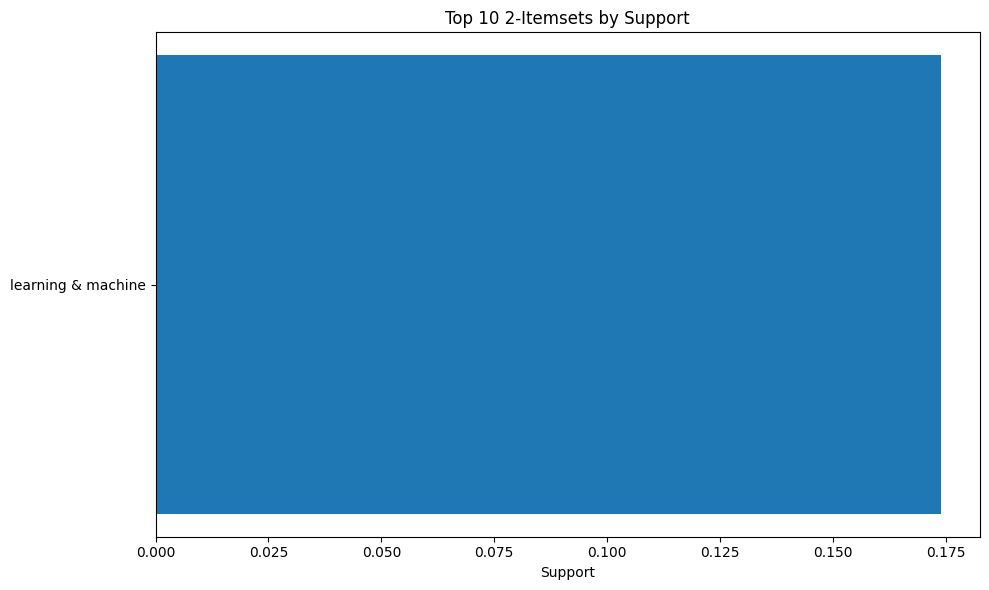

In [22]:
top_2_itemsets = frequent_itemsets[
    frequent_itemsets['length'] == 2
].nlargest(10, 'support')

labels = [' & '.join(sorted(list(itemset))) for itemset in top_2_itemsets['itemsets']]
plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], top_2_itemsets['support'][::-1])
plt.title("Top 10 2-Itemsets by Support")
plt.xlabel("Support")
plt.tight_layout()
plt.show()


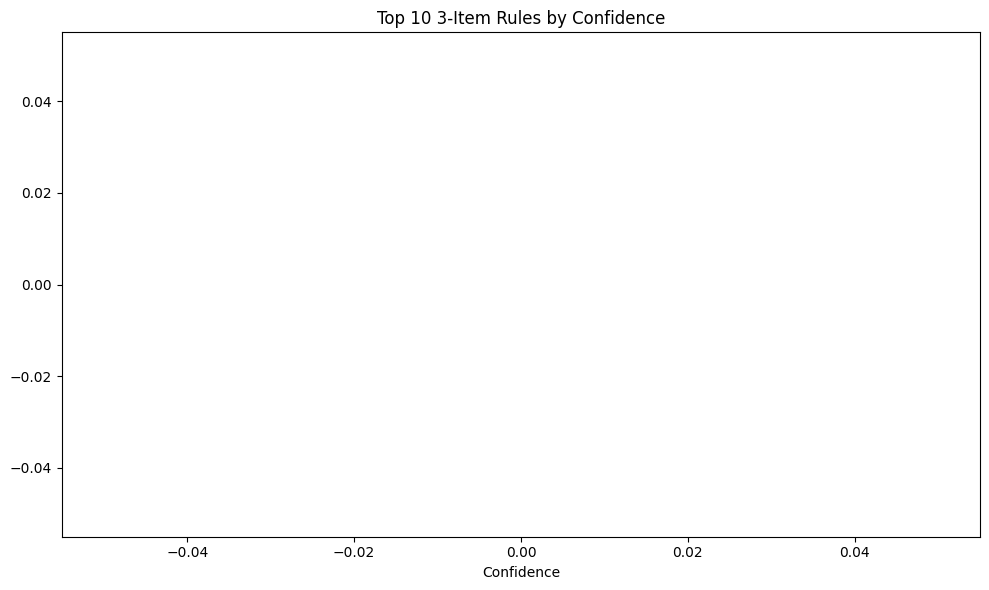

In [23]:
rules_3 = rules_lift[rules_lift['antecedents'].apply(len) + rules_lift['consequents'].apply(len) == 3]
top_3_conf = rules_3.nlargest(10, 'confidence')

labels = [f"{', '.join(ante)} → {', '.join(cons)}"
          for ante, cons in zip(top_3_conf['antecedents'], top_3_conf['consequents'])]

plt.figure(figsize=(10, 6))
plt.barh(labels[::-1], top_3_conf['confidence'][::-1])
plt.title("Top 10 3-Item Rules by Confidence")
plt.xlabel("Confidence")
plt.tight_layout()
plt.show()


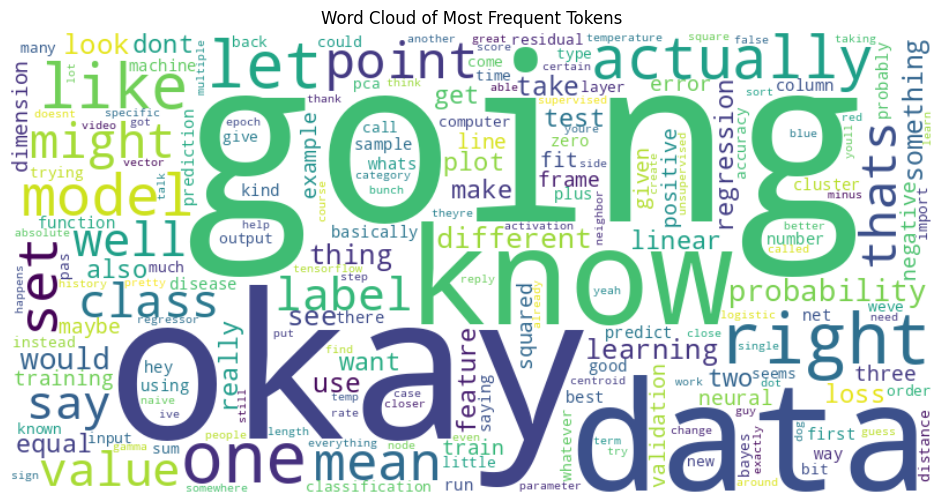

In [24]:
from wordcloud import WordCloud

# Use the unigram_counts you calculated earlier
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unigram_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Most Frequent Tokens")
plt.show()


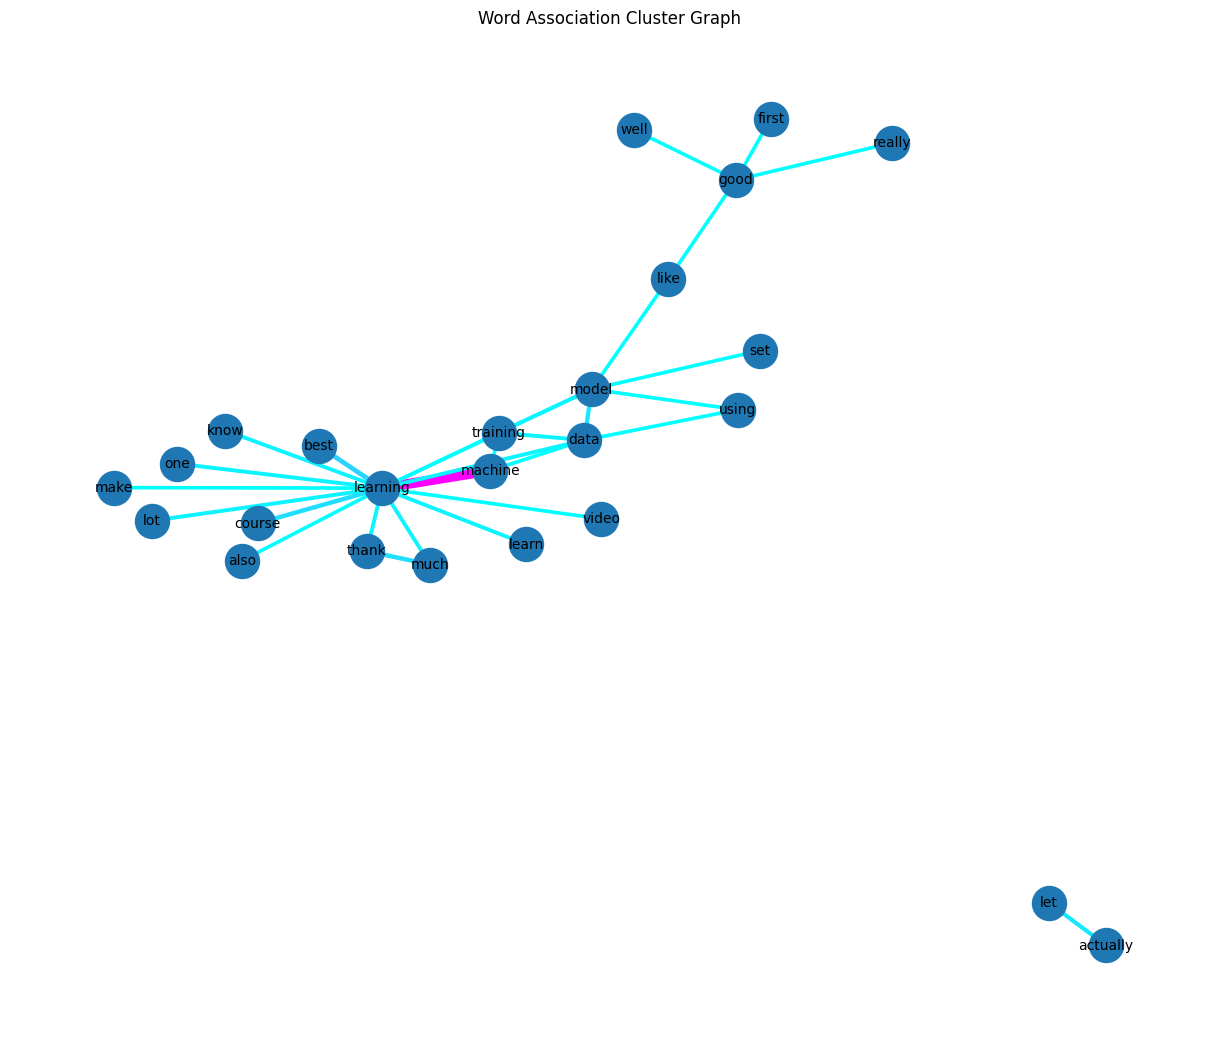

In [25]:
import networkx as nx

G = nx.Graph()

# Use filtered_pairs or top rules
top_pairs = Counter(filtered_pairs).most_common(30)

for (w1, w2), weight in top_pairs:
    G.add_edge(w1, w2, weight=weight)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw(G, pos, with_labels=True, node_size=600,
        width=[w * 0.2 for w in weights],
        edge_color=weights, edge_cmap=plt.cm.cool, font_size=10)
plt.title("Word Association Cluster Graph")
plt.show()


In [26]:
set_capt = set(get_rule_str(rules_capt))
set_comm = set(get_rule_str(rules_lift))
set_merge = set(get_rule_str(rules_merged))


In [27]:
print("🟢 Shared Rules:", set_capt & set_comm)
print("🔵 Only in Comments:", set_comm - set_capt)
print("🟠 Only in Captions:", set_capt - set_comm)


🟢 Shared Rules: set()
🔵 Only in Comments: {"frozenset({'machine'}) → frozenset({'learning'})", "frozenset({'learning'}) → frozenset({'machine'})"}
🟠 Only in Captions: {"frozenset({'get'}) → frozenset({'rid', 'let', 'actually'})", "frozenset({'equal'}) → frozenset({'say'})", "frozenset({'get', 'let', 'actually'}) → frozenset({'rid'})", "frozenset({'rid'}) → frozenset({'get'})", "frozenset({'rid', 'let', 'actually'}) → frozenset({'get'})", "frozenset({'get'}) → frozenset({'actually'})", "frozenset({'rid', 'actually'}) → frozenset({'get', 'let'})", "frozenset({'get'}) → frozenset({'let', 'actually'})", "frozenset({'get', 'actually'}) → frozenset({'rid'})", "frozenset({'rid', 'let'}) → frozenset({'get', 'actually'})", "frozenset({'get', 'let'}) → frozenset({'rid'})", "frozenset({'accuracy', 'let'}) → frozenset({'actually'})", "frozenset({'rid'}) → frozenset({'get', 'actually'})", "frozenset({'rid', 'get'}) → frozenset({'let', 'actually'})", "frozenset({'actually'}) → frozenset({'accuracy'}

In [29]:

# Save final cleaned basket list (used for transactions)
pd.DataFrame({'cleaned_tokens': cleaned_transactions}).to_csv("/content/drive/MyDrive/CSE477/final_cleaned_transactions.csv", index=False)

# Save filtered frequent itemsets
frequent_itemsets_filtered.to_csv("/content/drive/MyDrive/CSE477/final_frequent_itemsets.csv", index=False)

# Save final rules
rules_lift.to_csv("association_rules.csv", index=False)

print("✔ Final datasets saved.")



✔ Final datasets saved.


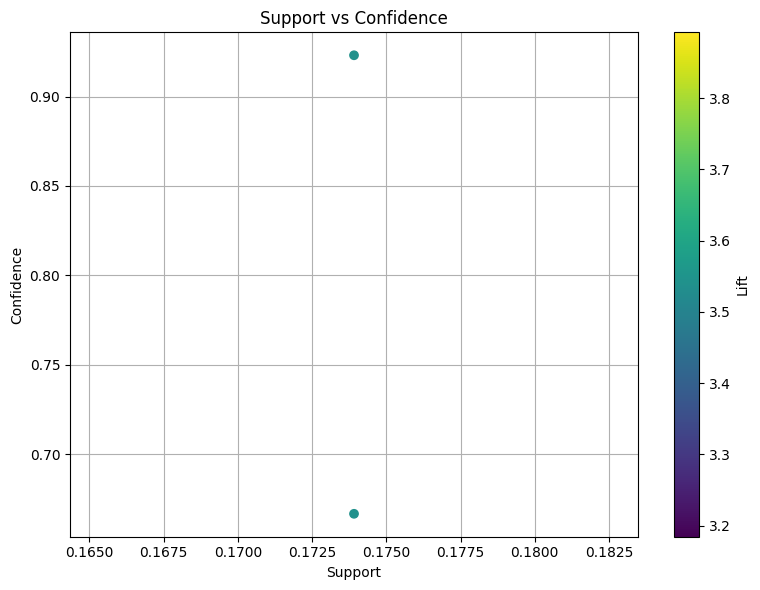

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(rules_lift['support'], rules_lift['confidence'], c=rules_lift['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.grid(True)
plt.tight_layout()
plt.savefig("support_vs_confidence.png")
